# Fundamental diagrams of pedestrian flow from empirical video data

## Author
Étienne Beauchamp  
M.A.Sc. candidate, Department of Civil, Geological and Mining Engineering  
Polytechnique Montréal, C.P. 6079, succ. Centre-Ville  
Montréal (Québec) Canada H3C 3A7  
Phone: (514) 340-4711 ext. 4210  
Email: etienne-2.beauchamp@polymtl.ca

## Overview
This code was written for a project done as part of the course *CIV6705 - Théorie de la circulation*. It uses methods from the TrafficIntelligence Python module to draw fundamental diagrams of pedestrian data extracted from video recordings.

Before getting started, you will need to install the following:
* Python 3.5.6 (other versions were not tested) with most of the standard scientific packages (e.g., numpy, matplotlib, pandas, etc.). I recommend installing [Anaconda](https://www.anaconda.com/download/#linux);
* [TrafficIntelligence](https://bitbucket.org/Nicolas/trafficintelligence/wiki/Home);
* [OpenCV 3.4.3](https://anaconda.org/conda-forge/opencv).

In [1]:
from trafficintelligence import storage, moving
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Point
from shapely.geometry import Polygon

import math
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [2]:
objects = storage.loadTrajectoriesFromSqlite('Donnees/1014AM_July 11_2014(E to W).sqlite','feature')

frameRate = 30
delatT    = 90*frameRate # 90 s cycle with a green time of 40 s

In [3]:
# for o in objects:
#     o.plot()

### Data filtering

In [4]:
# Removing points associated with vehicles according to the speed


In [5]:
# Removing points associated with vehicles according to the orientation of the trajectories


In [6]:
# Aggregate data according to the direction of the pedestrians


### Voronoï diagram technique

In [7]:
# Function found at: https://gist.github.com/pv/8036995
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates of input vertices, with 'points at infinity' 
        appended to the end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

In [14]:
# https://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates
def PolygonArea(corners):
    n = len(corners) # of corners
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += corners[i][0] * corners[j][1]
        area -= corners[j][0] * corners[i][1]
    area = abs(area) / 2.0
    return area

In [9]:
points = np.array([[0,0]])
speed = []

for o in objects:
    if(o.existsAtInstant(10)):
        pos = o.getPositionAtInstant(10)
        points = np.append(points, [pos.aslist()], axis = 0)
        speed.append(o.getVelocityAtInstant(10).norm2()*frameRate)

points = points[1:]

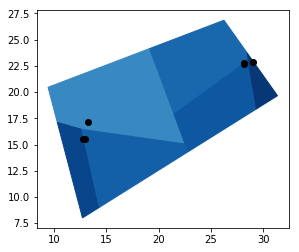

In [10]:
# Limits of the study area
min_x = 9.45423
max_x = 31.3422
min_y = 7.99941
max_y = 26.8535

limits   = [[12.7377, min_y], [min_x, 20.4617], [26.2292, max_y], [max_x, 19.6558]]
limitBox = Polygon([[12.7377, min_y], [min_x, 20.4617], [26.2292, max_y], [max_x, 19.6558]])

# Minimum and maximum values of the polygon areas for normalization
minima = 0
maxima = PolygonArea(limits)

# normalize chosen colormap
norm = mpl.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues_r)


vor = Voronoi(points)

regions, vertices = voronoi_finite_polygons_2d(vor)

area    = []
density = []

i = 0

# colorize
for region in regions:
    polygon = vertices[region]
    poly = Polygon(polygon)
    poly = poly.intersection(limitBox)
    polygon = [p for p in poly.exterior.coords]
    plt.fill(*zip(*polygon), color = mapper.to_rgba(PolygonArea(polygon)))
    area.append(PolygonArea(polygon))
    density.append(1/PolygonArea(polygon))
    i += 1

plt.gca().set_aspect('equal', adjustable='box')
plt.plot(points[:, 0], points[:, 1], 'ko')

plt.show()

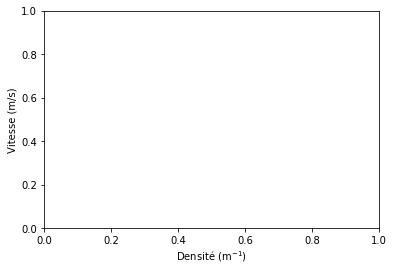

In [11]:
# plt.title()
plt.xlabel(r'Densité (m$^{-1}$)')
plt.ylabel("Vitesse (m/s)")
plt.show()

### Edie's definition extension

In [2]:
objects = storage.loadTrajectoriesFromSqlite('Donnees/1014AM_July 11_2014(E to W).sqlite','feature',20000)

frameMin = 100
frameMax = 1000

min_x = 9.45423
max_x = 31.3422
min_y = 7.99941
max_y = 26.8535

limits = [[12.7377, min_y], [min_x, 20.4617], [26.2292, max_y], [max_x, 19.6558]]

box = Polygon(limits)

In [3]:
def objectsAppearingBetweenFrames(frameMin, frameMax):
    objectsAppearingBetweenFrames = []

    for o in objects:
        objectTrajectoryFirstFrame = o.getFirstInstant()
        objectTrajectoryLastFrame  = o.getLastInstant()

        # The trajectory of the object is, at some point, between the first and the last sampled frame
        if(objectTrajectoryFirstFrame < frameMax and objectTrajectoryLastFrame > frameMin):
            objectNumber = o.getNum()

            if(objectNumber not in objectsAppearingBetweenFrames):
                objectsAppearingBetweenFrames.append(objectNumber)
    
    return objectsAppearingBetweenFrames

In [4]:
def pointIsInBox(objectID, frame, box):
    pos   = objects[objectID].getPositionAtInstant(frame) # X et Y coordinates at the given frame
    point = Point(pos[0], pos[1])

    return box.contains(point)

In [5]:
def findEntries(box, firstFrame, lastFrame, objectsPresent):
    # Initialize the DataFrame for the first moment in the volume
    colEntries = ['trajectoryID', 'coordinateInit', 'frameInit']
    entries = pd.DataFrame(columns = colEntries)

    # Iterate from first to the last studied frame
    for frame in range(frameMin, frameMax + 1):

        # Find the objects that are present in the frame
        for objectNum in objectsPresent:

            # Check if the trajectory is in the frame
            if(objects[objectNum].existsAtInstant(frame)):

                # Check if the trajectory is new
                if(objectNum not in entries.trajectoryID.tolist()):

                    # Check wether the point is in the limits of the study area
                    if(pointIsInBox(objectNum, frame, box)):
                        firstCoordinates = objects[objectNum].getPositionAtInstant(frame)

                        # Create a dataframe row to be appended
                        df = pd.DataFrame([[objectNum, firstCoordinates, frame]], columns = colEntries)
                        entries = entries.append(df, ignore_index = True) # Append the new row
    return entries

In [6]:
objectsPresent = objectsAppearingBetweenFrames(frameMin, frameMax)

entries = findEntries(box, frameMin, frameMax, objectsPresent)

In [7]:
def findExits(box, entriesList):
    # Initialize the DataFrame for the last moment in the volume
    colExits = ['trajectoryID', 'coordinateLast', 'frameLast']
    exits = pd.DataFrame(columns = colExits)

    for objectNum in entriesList:
        lastFrame = objects[objectNum].getLastInstant()
        lastPos   = objects[objectNum].getPositionAtInstant(lastFrame)

        # Case where the trajectory ends in the area
        if(pointIsInBox(objectNum, lastFrame, box)):
            lastCoordinates = lastPos

        # The trip ends out of bound
        else:
            # Finding the last coordinates that were in the area
            while(not pointIsInBox(objectNum, lastFrame, box)):
                lastFrame -= 1

            lastCoordinates = objects[objectNum].getPositionAtInstant(lastFrame)

        df = pd.DataFrame([[objectNum, lastCoordinates, lastFrame]], columns = colExits)
        exits = exits.append(df, ignore_index = True) # Append the new row
    return exits

In [8]:
entriesList = entries.trajectoryID.tolist()

exits = findExits(box, entriesList)

In [9]:
def computeDistance(trajID):
    # Find the dataframe corresponding to the desired ID
    trajectoryEntryDataFrame = entries.loc[entries.trajectoryID == trajID]
    trajectoryExitDataFrame  = exits.loc[exits.trajectoryID == trajID]
    
    # Extract the first and final positions
    x_ini = trajectoryEntryDataFrame.coordinateInit.values[0][0]
    y_ini = trajectoryEntryDataFrame.coordinateInit.values[0][1]

    x_las = trajectoryExitDataFrame.coordinateLast.values[0][0]
    y_las = trajectoryExitDataFrame.coordinateLast.values[0][1]

    return math.sqrt((x_ini - x_las)**2 + (y_ini - y_las)**2)

In [10]:
def computeTime(trajID):
    # Find the dataframe corresponding to the desired ID
    trajectoryEntryDataFrame = entries.loc[entries.trajectoryID == trajID]
    trajectoryExitDataFrame  = exits.loc[exits.trajectoryID == trajID]
    
    # Extract the first and final frame values
    t_ini = trajectoryEntryDataFrame.frameInit.values[0]
    t_las = trajectoryExitDataFrame.frameLast.values[0]
    
    return (t_las - t_ini) / frameRate

In [17]:
frameRate = 30
delatT    = 90*frameRate

In [18]:
sumOfDistances = 0
sumOftime      = 0

for tID in entriesList:
    sumOfDistances += computeDistance(tID)
    sumOftime      += computeTime(tID)

XY = PolygonArea(limits)
T  = delatT/frameRate

q = sumOfDistances/T*XY
k = sumOftime/T*XY
v = sumOfDistances/sumOftime

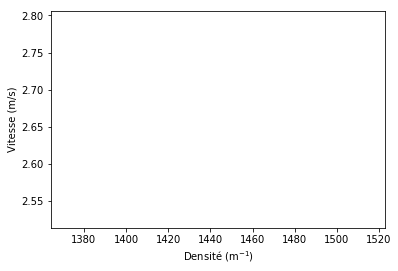

In [19]:
plt.plot(k,v)
# plt.title()
plt.xlabel(r'Densité (m$^{-1}$)')
plt.ylabel("Vitesse (m/s)")
plt.show()

In [20]:
q

3840.2692271605647

In [21]:
k

1443.6014788687128

In [22]:
v

2.66020039697522